In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import joblib
import os

In [42]:
sns.set()

# Import data

In [43]:
DATASET_PATH = '/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/data/income_per_day.csv'
df_raw = pd.read_csv(DATASET_PATH)

In [44]:
def feature_engineering(DF):
    for lag in range(1,5, 2):
        DF[f'Lag{lag}'] = DF['income'].shift(lag)
    DF['RollingMean'] = DF['income'].rolling(window=3).mean()
    DF.dropna(inplace=True)

    # Convert Date to numeric features
    DF['date'] = pd.to_datetime(DF['date'])
    DF['Year'] = DF['date'].dt.year
    DF['Month'] = DF['date'].dt.month
    DF['Day'] = DF['date'].dt.day
    DF.set_index('date', inplace=True)

    return DF

In [45]:
df = feature_engineering(df_raw)

In [46]:
def split_processed_data(DF):
        X_train, X_test, y_train, y_test = train_test_split(
                DF.drop(columns='income'),
                DF[['income']],
                test_size = 0.2, 
                random_state = 42,
                shuffle=False)
        return X_train, X_test, y_train, y_test 


In [47]:
X_train, X_test, y_train, y_test  = split_processed_data(df)

In [48]:
# Function to create pipelines
def create_pipeline(model):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    return pipeline

# Function to train and evaluate models
def set_train_and_evaluation(model, X_train, y_train, X_test, y_test):
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

def get_best_model(models):
    results = {}
    # Train and evaluate each model
    for name, model in models.items():
        results[name] = set_train_and_evaluation(
            model, 
            X_train, 
            y_train,
            X_test, 
            y_test)
        
    best_model_df = (pd.DataFrame(results.items())
                  .rename(columns={0:'model', 1:'mse'})
                  .sort_values('mse', ascending=True)
                  .head(1)
                  )
    print(best_model_df)
    return best_model_df['model'].values[0]

# List of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=False),
    'LightGBM': LGBMRegressor()
}
best_model = get_best_model(models)


/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 241, number of used features: 5
[LightGBM] [Info] Start training from score 111874713.414419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
# Here I just use Linear Regression params, I could be necessary to 
# implement optimizations for other models

def get_best_params(X_train, y_train, best_model):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', models[best_model])
    ])
    pipeline = pipeline.fit(X_train, y_train)

    # Define the parameter grid for grid search specific to LinearRegression
    param_grid = {
        'model__fit_intercept': [True, False],
        'model__copy_X': [True, False]  # Prefix with 'model__' since it's inside the pipeline
    }

    # Set up the grid search with TimeSeriesSplit for time series data
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("Best Parameters: ", best_params)
    print("Best Score: ", grid_search.best_score_)

    return best_params

best_params = get_best_params(X_train, y_train, best_model)
print(best_params)
# Predict with the best model
#y_pred = best_model.predict(X_test)


Best Parameters:  {'model__copy_X': True, 'model__fit_intercept': True}
Best Score:  -5839688363901248.0
{'model__copy_X': True, 'model__fit_intercept': True}


In [50]:
def full_featured_data(DF):
    X = DF[['Lag1', 'Lag3', 'RollingMean', 'Year', 'Month', 'Day']]
    y = DF['income']
    return X, y

def train_final_model(X, y):
    # Create and train the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression(
            fit_intercept=best_params['model__fit_intercept'], 
            copy_X=best_params['model__copy_X']))
    ])
    return pipeline.fit(X, y)

X, y = full_featured_data(df)
final_model = train_final_model(X, y)

In [51]:
# Generate the next n days
def get_n_future_days(n_days, DF):
    last_date = DF.index.max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_days)

    # Prepare the future DataFrame with lags and rolling mean
    future_df = pd.DataFrame({'date': future_dates})
    future_df['Year'] = future_df['date'].dt.year
    future_df['Month'] = future_df['date'].dt.month
    future_df['Day'] = future_df['date'].dt.day

    return future_df
    
dates_to_forecast = get_n_future_days(DF=df, n_days=7)


In [52]:

def get_forecasting(DF, future_DF, model):
    # Initialize an empty list to store future predictions
    future_predictions = []
    days_in_future = len(future_DF.index)
    
    # Initialize future DataFrame with correct lags and rolling mean
    for i in range(days_in_future):
        if i == 0:
            future_DF.loc[i, 'Lag1'] = DF.iloc[-1]['income']
            future_DF.loc[i, 'Lag3'] = DF.iloc[-3]['income']
            future_DF.loc[i, 'RollingMean'] = DF.iloc[-3:]['income'].mean()
        else:
            future_DF.loc[i, 'Lag1'] = future_predictions[-1]
            future_DF.loc[i, 'Lag3'] = future_predictions[-3] if i > 2 else DF.iloc[-2]['income']
            future_DF.loc[i, 'RollingMean'] = np.mean(future_predictions[-3:]) if i >= 3 else DF.iloc[-3:]['income'].mean()

        # Prepare features for the current prediction
        X_future = future_DF.loc[i, ['Lag1', 'Lag3', 'RollingMean', 'Year', 'Month', 'Day']].values.reshape(1, -1)

        # Predict income and store it
        predicted_value = model.predict(X_future)[0]
        future_predictions.append(predicted_value)

    # Add predictions to future_DF
    future_DF['Predicted_Income'] = future_predictions
    
    return future_DF

def prepare_future_df(DF, future_DF):
    # Initialize an empty list to store future features
    future_features = []
    days_in_future = len(future_DF.index)
    
    # Initialize future DataFrame with correct lags and rolling mean
    for i in range(days_in_future):
        if i == 0:
            # For the first prediction, use the historical DF values
            future_DF.loc[i, 'Lag1'] = DF.iloc[-1]['income']
            future_DF.loc[i, 'Lag3'] = DF.iloc[-3]['income']
            future_DF.loc[i, 'RollingMean'] = DF.iloc[-3:]['income'].mean()
        else:
            # For subsequent predictions, check if 'Predicted_Income' exists
            if 'Predicted_Income' in future_DF.columns:
                future_DF.loc[i, 'Lag1'] = future_DF.loc[i - 1, 'Predicted_Income']
                future_DF.loc[i, 'Lag3'] = future_DF.loc[i - 3, 'Predicted_Income'] if i > 2 else DF.iloc[-2]['income']
                future_DF.loc[i, 'RollingMean'] = np.mean(future_DF.loc[i - 3:i - 1, 'Predicted_Income']) if i >= 3 else DF.iloc[-3:]['income'].mean()
            else:
                # Use historical DF for initial lag and rolling mean values
                future_DF.loc[i, 'Lag1'] = DF.iloc[-1]['income']
                future_DF.loc[i, 'Lag3'] = DF.iloc[-3]['income']
                future_DF.loc[i, 'RollingMean'] = DF.iloc[-3:]['income'].mean()

        # Prepare features for the current prediction
        X_future = future_DF.loc[i, ['Lag1', 'Lag3', 'RollingMean', 'Year', 'Month', 'Day']].values
        future_features.append(X_future)
    
    return future_DF, future_features


In [53]:
data1, data2 = prepare_future_df(df, dates_to_forecast)

In [54]:
data1

,date,Year,Month,Day,Lag1,Lag3,RollingMean
0,2011-12-10,2011,12,10,1.194737e+08,3.584565e+08,4.098124e+08
1,2011-12-11,2011,12,11,1.194737e+08,3.584565e+08,4.098124e+08
2,2011-12-12,2011,12,12,1.194737e+08,3.584565e+08,4.098124e+08
3,2011-12-13,2011,12,13,1.194737e+08,3.584565e+08,4.098124e+08
4,2011-12-14,2011,12,14,1.194737e+08,3.584565e+08,4.098124e+08
5,2011-12-15,2011,12,15,1.194737e+08,3.584565e+08,4.098124e+08
6,2011-12-16,2011,12,16,1.194737e+08,3.584565e+08,4.098124e+08


In [55]:

forecasting = get_forecasting(DF=df, future_DF=dates_to_forecast, model=final_model)

/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/py

        date  Predicted_Income
0 2011-12-10      5.713460e+08
1 2011-12-11      3.336164e+08
2 2011-12-12      4.574969e+08
3 2011-12-13      4.608903e+08
4 2011-12-14      4.019707e+08
5 2011-12-15      4.672814e+08
6 2011-12-16      4.375515e+08


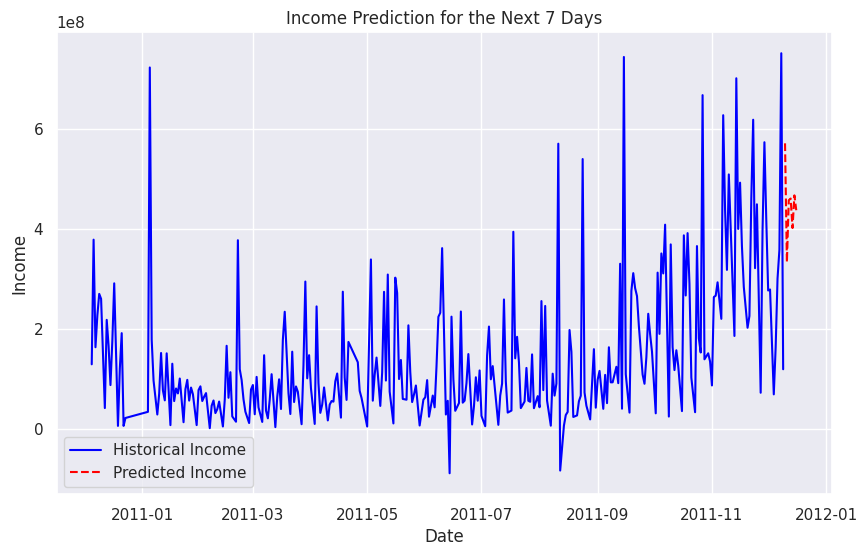

In [56]:
def plot_forecasting(forecasting, DF):
    # Print the predicted values
    print(forecasting[['date', 'Predicted_Income']])

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(DF.index, DF['income'], label='Historical Income', color='blue')
    plt.plot(forecasting['date'], forecasting['Predicted_Income'], label='Predicted Income', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Income')
    plt.title(f'Income Prediction for the Next {len(forecasting.index)} Days')
    plt.legend()
    plt.show()

plot_forecasting(forecasting, df)

In [57]:
def save_model(final_model):
    model_filename = 'forecasting_income_model.pkl'
    models_dir = os.path.join(os.path.dirname(os.getcwd()), 'models')
    os.makedirs(models_dir, exist_ok=True)
    model_path = os.path.join(models_dir, model_filename)
    # Save the model
    joblib.dump(final_model, model_path)
    
save_model(final_model)


In [58]:
import os
import joblib

def load_model(model_filename):
    """
    Load a model from the 'models' directory.

    Parameters:
    - model_filename (str): The filename of the saved model.

    Returns:
    - The loaded model object.
    """
    # Construct the path to the 'models' directory
    models_dir = os.path.join(os.path.dirname(os.getcwd()), 'models')

    # Normalize the path
    models_dir = os.path.normpath(models_dir)

    # Define the full path to the model file
    model_path = os.path.join(models_dir, model_filename)

    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"The model file '{model_filename}' was not found in '{models_dir}'.")

    # Load the model using joblib
    loaded_model = joblib.load(model_path)

    print(f"Model loaded from: {model_path}")
    return loaded_model

model = load_model('forecasting_income_model.pkl')


Model loaded from: /home/aleksei/Desktop/projects/MLOPs-boootcamp-project/models/forecasting_income_model.pkl


In [59]:
predictions = model.predict(data2)
data1['predictions'] = predictions

/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [60]:
data1

,date,Year,Month,Day,Lag1,Lag3,RollingMean,Predicted_Income,predictions
0,2011-12-10,2011,12,10,1.194737e+08,3.584565e+08,4.098124e+08,5.713460e+08,5.713460e+08
1,2011-12-11,2011,12,11,5.713460e+08,7.515071e+08,4.098124e+08,3.336164e+08,5.707701e+08
2,2011-12-12,2011,12,12,3.336164e+08,7.515071e+08,4.098124e+08,4.574969e+08,5.701943e+08
3,2011-12-13,2011,12,13,4.574969e+08,5.713460e+08,4.541531e+08,4.608903e+08,5.696184e+08
4,2011-12-14,2011,12,14,4.608903e+08,3.336164e+08,4.173345e+08,4.019707e+08,5.690426e+08
5,2011-12-15,2011,12,15,4.019707e+08,4.574969e+08,4.401193e+08,4.672814e+08,5.684667e+08
6,2011-12-16,2011,12,16,4.672814e+08,4.608903e+08,4.433808e+08,4.375515e+08,5.678909e+08


        date  Predicted_Income
0 2011-12-10      5.713460e+08
1 2011-12-11      3.336164e+08
2 2011-12-12      4.574969e+08
3 2011-12-13      4.608903e+08
4 2011-12-14      4.019707e+08
5 2011-12-15      4.672814e+08
6 2011-12-16      4.375515e+08


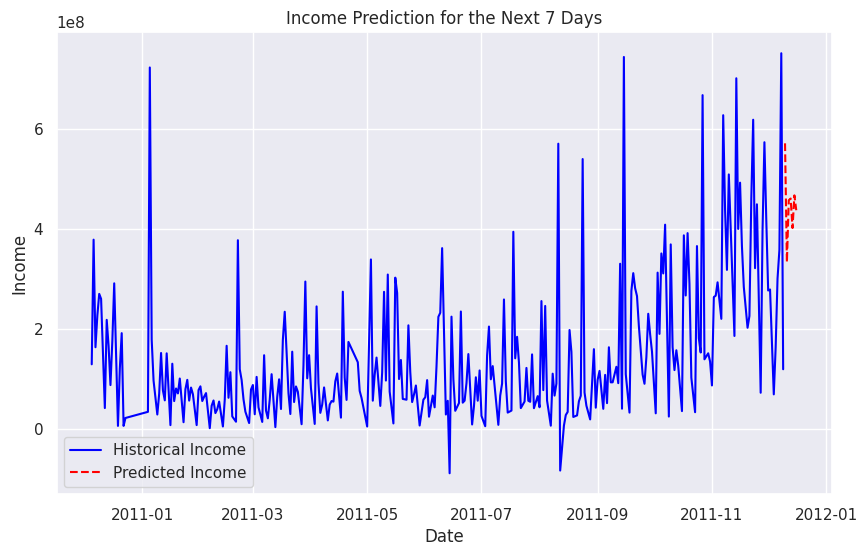

In [61]:
plot_forecasting(data1, df)